In [1]:
# import libraries for this notebook
import numpy as np
import pandas as pd
import time
from tempfile import mkdtemp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from xgboost import plot_tree
from xgboost import plot_importance
from lightgbm import plot_importance

import warnings
warnings.filterwarnings('ignore')

/Users/sileihuo/opt/anaconda3/envs/myport/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions Defined

In [2]:
def model_auc_score (modelname):
    y_prob = modelname.predict_proba(X_val)[:, 1]
    fprs, lprs, thresholds = roc_curve(y_val, y_prob)
    model_auc_score = roc_auc_score(y_val, y_prob)
    return model_auc_score, fprs, lprs, thresholds

def model_auc_plot(result, modelname):
    plt.plot(result[1], result[2], color = 'cornflowerblue',
            lw=1, label = f'AUC_{modelname} = %0.6f' % result[0])
    plt.plot([0, 1], [0, 1], color = 'navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for Payment Fraud Detection')
    plt.legend(loc="best")

# Load Dataset

**Column Description**

From Data Description:(https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203)

Categorical Features:

- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9
- DeviceType
- DeviceInfo
- id_12 - id_38

In [3]:
df_train = pd.read_csv('data/train_clean.csv')

In [4]:
df_test = pd.read_csv('data/test_clean.csv')

In [5]:
# check data table

df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card5_grouped,addr1_grouped,addr2_grouped,P_email_grouped,R_email_grouped,id_31_grouped,id_13_grouped,id_17_grouped,id_19_grouped,id_20_grouped
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,168.43,315.00,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,102.00,325.00,87.0,gmail,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,166.00,330.00,87.0,outlook,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,117.00,476.00,87.0,yahoo,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,102.00,320.58,87.0,gmail,NaN,samsung,NaN,166.0,542.0,375.75


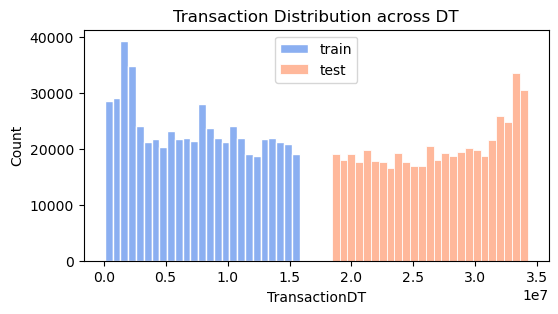

In [6]:
# check the distribution for train and test across TransactionDT

plt.figure(figsize=(6,3))
sns.histplot(df_train['TransactionDT'], bins=25, label='train', color='cornflowerblue', edgecolor='white')
sns.histplot(df_test['TransactionDT'], bins=25, label='test', color='lightsalmon', edgecolor='white')
plt.legend()
plt.title('Transaction Distribution across DT')
plt.show()

It shows the train and test set are split according transaction timeline, however transactions are fraud or not is not normally dependent on time, so still choose a stratified CV split.

In [7]:
print(df_train.shape, df_test.shape) 

(590540, 372) (506691, 371)


In [8]:
# checking object columns

df_train.select_dtypes('object').columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
       'id_31', 'DeviceType', 'P_email_grouped', 'R_email_grouped',
       'id_31_grouped'],
      dtype='object')

So, there are in total 372 columns in the train set, among which 13 columns are added via preprocessing for EDA, so will delete them for modeling.

Since will use tree based models, categorical columns will be further processed with Label Encoding, including both 7 object columns, and below ones:
- card1, 2, 3 &5
- addr1, 2
- id_13, 17, 19 & 20



In [9]:
grouped_columns = list(df_train.columns[df_train.columns.str.contains('grouped')])

grouped_columns.append('card1_bin')

grouped_columns

['card2_grouped',
 'card3_grouped',
 'card5_grouped',
 'addr1_grouped',
 'addr2_grouped',
 'P_email_grouped',
 'R_email_grouped',
 'id_31_grouped',
 'id_13_grouped',
 'id_17_grouped',
 'id_19_grouped',
 'id_20_grouped',
 'card1_bin']

In [10]:
# Check if there's infinitive values in the dataframe
# df_train.isin([nvalue_counts -np.inf]).sum().sum()
# there is no infinitive values in the dataset

# Setting dependent and independent variables

Drop preprocessed columns from the dataframe

In [10]:
# drop duplicated columns

X_trainall = df_train.drop(grouped_columns, axis=1)
X_test = df_test.drop(grouped_columns, axis=1)

In [11]:
print(X_trainall.shape, X_test.shape)

(590540, 359) (506691, 358)


In [12]:
# Drop target, ID and DT columns

X_trainall = X_trainall.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_trainall = df_train['isFraud']

X_test = X_test.drop(['TransactionDT', 'TransactionID'], axis=1)

In [13]:
print(X_trainall.shape, y_trainall.shape, X_test.shape)

(590540, 356) (590540,) (506691, 356)


In [14]:
# Splitting data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainall,
                                                  y_trainall,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=y_trainall)

# Check 
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(413378, 356) (177162, 356) (413378,) (177162,)


## Ordinal Encoding columns

In [15]:
# set column list for encoding

oe_columns = list(X_trainall.select_dtypes('object').columns)

oe_columns.extend(['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'id_13', 'id_17', 'id_19', 'id_20'])

oe_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_31',
 'DeviceType',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'id_13',
 'id_17',
 'id_19',
 'id_20']

In [16]:
# check

len(oe_columns)

17

# Model1 - XGBoost

In [17]:
oe_tf = ColumnTransformer(transformers = [('oe_transform', 
                                           OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), 
                                           oe_columns)],
                          remainder = "passthrough")

In [49]:
start = time.time()

depth = range(1, 35, 5)

cvscore_xgbm = []

cachedir = mkdtemp()

for max_depth in depth:
    estimators_xgbm = [('transformer', oe_tf),
                       ('model', XGBClassifier(max_depth=max_depth, 
                                               max_leaves= 256,
                                               n_estimators=50,
                                               learning_rate=0.02,
                                               colsample_bytree=0.7,
                                               subsample=0.8,
                                               random_state=42
                                               #verbosity=1
                                              ))]
    
    pipe_xgbm = Pipeline(estimators_xgbm, memory = cachedir)
    
    score = np.mean(cross_val_score(pipe_xgbm, X_train, y_train, cv=5))
    
    cvscore_xgbm.append(score)

stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 4383.77 seconds


In [50]:
cvscore_xgbm

[0.9678284776113804,
 0.9732472461128385,
 0.9763872279917438,
 0.9778120736770802,
 0.9784845820225463,
 0.9789538866260157,
 0.9790554884970142]

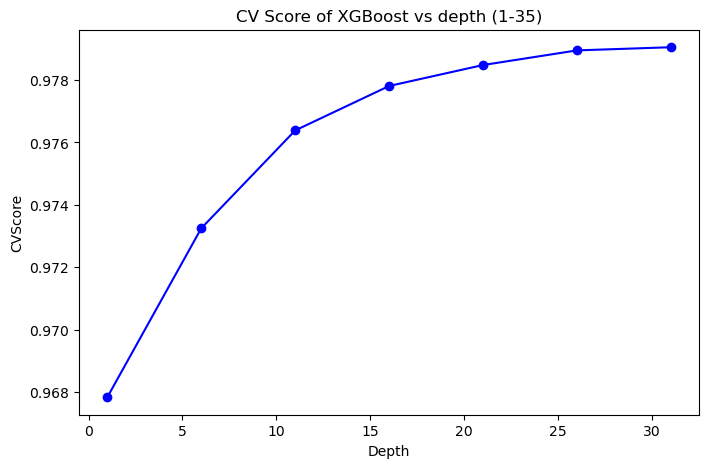

In [51]:
plt.figure(figsize=(8,5))
plt.plot(depth, cvscore_xgbm, 'bo-')
plt.xlabel('Depth')
plt.ylabel('CVScore')
plt.title('CV Score of XGBoost vs depth (1-35)')
plt.show()

The improvement of the model performance is diminishing after max_depth reaches 25, so will choose a depth of 30 for further tuning.

In [52]:
start = time.time()

estimators_xgbm = [('transformer', oe_tf), ('model', XGBClassifier())]

pipe_xgbm = Pipeline(estimators_xgbm)

param_grid_xgbm = [{'model': [XGBClassifier()],
                   'transformer': [oe_tf],
                   'model__max_depth': [30],
                   'model__max_leaves': [256],
                   'model__n_estimators': [50],
                   'model__learning_rate': [0.02],
                   'model__colsample_bytree': [0.5, 0.7],
                   'model__subsample': [0.6, 0.8],
                   'model__random_state': [42],
                   'model__verbosity': [1]}]

cv = StratifiedKFold(n_splits=5)

grid_xgbm = GridSearchCV(pipe_xgbm, param_grid_xgbm, cv=cv)
fitted_xgbm = grid_xgbm.fit(X_train, y_train)


stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 4736.89 seconds


In [53]:
fitted_xgbm.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=0.7, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.02, max_delta_step=None, max_depth=30,
               max_leaves=256, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, random_state=42, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=0.8,
               tree_method=None, validate_parameters=None, verbosity=1),
 'model__colsample_bytree': 0.7,
 'model__learning_rate': 0.02,
 'model__max_depth': 30,
 'model__max_leaves': 256,
 'model__n_estimators': 50,
 'model__random_state': 42,
 'model__subsample': 0.8,
 'model__verbosity': 1,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_transform',
           

In [56]:
fitted_xgbm.cv_results_['mean_test_score']

array([0.97797899, 0.97860312, 0.97838298, 0.97904823])

## XGBoost Optimised Model & Feature Importance

In [18]:
start = time.time()

estimators_xgbm_opt = [('transformer', oe_tf),
                       ('model', XGBClassifier(max_depth=30, 
                                               max_leaves= 256,
                                               n_estimators=100,
                                               learning_rate=0.02,
                                               colsample_bytree=0.7,
                                               subsample=0.8,
                                               random_state=42,
                                               verbosity=1))]

pipe_xgbm_opt = Pipeline(estimators_xgbm_opt)

pipe_xgbm_opt.fit(X_train, y_train)

stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 467.49 seconds


**XGBoost Feature Importance Reference**

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score

get_score(fmap='', importance_type='weight')

Get feature importance of each feature. For tree model Importance type can be defined as:

- ‘weight’: the number of times a feature is used to split the data across all trees.

- ‘gain’: the average gain across all splits the feature is used in.

- ‘cover’: the average coverage across all splits the feature is used in.

- ‘total_gain’: the total gain across all splits the feature is used in.

- ‘total_cover’: the total coverage across all splits the feature is used in.

In [122]:
# obtain feature importance (gain) from boosted tree model
xgbm_fscore = pipe_xgbm_opt.named_steps.model.get_booster().get_score(importance_type='gain')
# create a dataframe to save feature and importance value
xgbm_fscore_df = pd.DataFrame.from_dict(xgbm_fscore, orient = 'index', columns=['importance'])
# reset the index of the dataframe
xgbm_fscore_df.index = xgbm_fscore_df.index.map(lambda x: x[1:]).astype(int)
# check the dataframe
xgbm_fscore_df

,importance
278,599.702595
30,21.113088
31,11.747352
19,16.134500
217,23.732789
...,...
171,1.285105
50,1.809722
138,0.709885
156,0.485107


In [129]:
# create feature index
feature_index = np.array(xgbm_fscore_df.index)
# add original column name to feature importance
xgbm_fscore_df['features'] = X_train.columns[feature_index].values
# convert importance value to 2 decimal for better comparison
xgbm_fscore_df['importance'] = xgbm_fscore_df['importance'].round(2)
# check the dataframe
xgbm_fscore_df

,importance,features
278,599.70,V264
30,21.11,D4
31,11.75,D5
19,16.13,C7
217,23.73,V203
...,...,...
171,1.29,V128
50,1.81,V7
138,0.71,V95
156,0.49,V113


In [130]:
# add feature importance value by weight

xgbm_fscore_df['importance_weight'] = pipe_xgbm_opt.named_steps.model.get_booster().get_score(importance_type='weight').values()

In [132]:
xgbm_fscore_df

,importance,features,importance_weight
278,599.70,V264,200
30,21.11,D4,799
31,11.75,D5,3310
19,16.13,C7,3293
217,23.73,V203,84
...,...,...,...
171,1.29,V128,38
50,1.81,V7,18
138,0.71,V95,1
156,0.49,V113,1


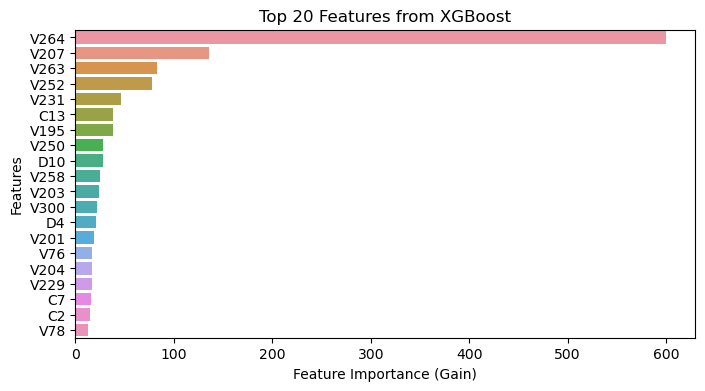

In [161]:
# plot feature importance by gain

plt.figure(figsize=(8,4))
sns.barplot(data=xgbm_fscore_df.sort_values(by='importance', ascending=False).head(20), x = 'importance', y = 'features')
plt.title('Top 20 Features from XGBoost')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.show()

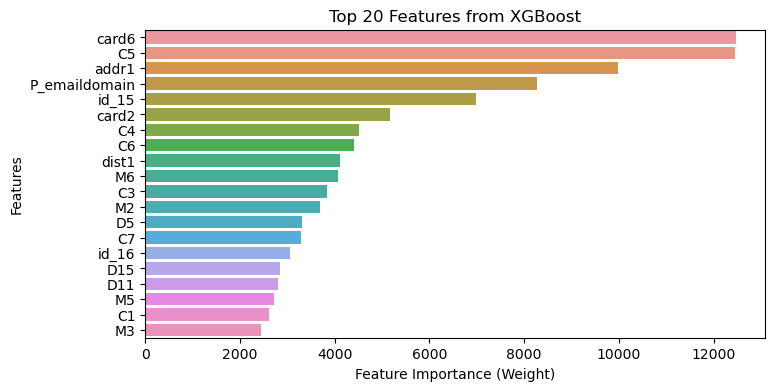

In [160]:
# plot feature importance by weight

plt.figure(figsize=(8,4))
sns.barplot(data=xgbm_fscore_df.sort_values(by='importance_weight', ascending = False).head(20), x = 'importance_weight', y = 'features')
plt.title('Top 20 Features from XGBoost')
plt.xlabel('Feature Importance (Weight)')
plt.ylabel('Features')
plt.show()

##  XGBoost Model Result

In [139]:
result_xgbm_opt = model_auc_score(pipe_xgbm_opt)

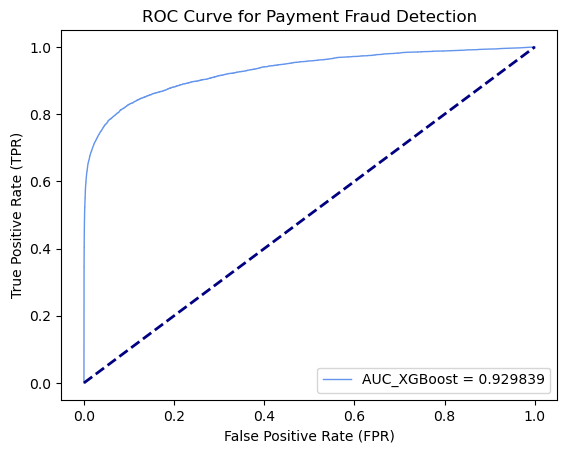

In [140]:
model_auc_plot(result_xgbm_opt, 'XGBoost')

Increasing the number of estimators actually imporved the performance, however, due to time and resource constraints, will not further increasing it.

# Model2 - LGBM

After running GridSearch on hyperparameters for LGBM, here is the optimised model

In [143]:
# Model construction
start = time.time()

estimators_lgbm_opt = [('transformer', oe_tf),
                       ('model', LGBMClassifier(boosting_type='gbdt',
                                                objective='binary',
                                                max_depth=20,
                                                num_leaves=256,
                                                learning_rate=0.03,
                                                n_estimators=100,
                                                colsample_bytree=0.9,
                                                subsample=0.7,
                                               min_child_samples=50,
                                               importance_type='gain',
                                               random_state=42,
                                               verbosity=-1))]

pipe_lgbm_opt = Pipeline(estimators_lgbm_opt)

fitted_lgbm = pipe_lgbm_opt.fit(X_train, y_train)

stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 15.83 seconds


In [177]:
fitted_lgbm.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_transform',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'id_31',
                                                   'DeviceType', 'card1',
                                                   'card2', 'card3', 'card5',
                                                   'addr1', 'addr2', 'id_13',
                                                   'id_17', 'id_19',
                                                   'id_20'])])),
                ('model',
 

## LGBM Feature Importance

**LGBM Feature Importance**

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html

In [199]:
# create the importance datafram
lgbm_fscore_df = pd.DataFrame({
    'column_num': pipe_lgbm_opt.named_steps.model.booster_.feature_name(),
    'importance_gain': pipe_lgbm_opt.named_steps.model.booster_.feature_importance(importance_type='gain'),
    'importance_split': pipe_lgbm_opt.named_steps.model.booster_.feature_importance(importance_type='split')
})

# check the dataframe
lgbm_fscore_df

,column_num,importance_gain,importance_split
0,Column_0,3882.915706,104
1,Column_1,3829.574368,166
2,Column_2,16084.677089,285
3,Column_3,17967.200273,669
4,Column_4,23929.219024,380
...,...,...,...
351,Column_351,380.756394,11
352,Column_352,41.628300,2
353,Column_353,337.236640,20
354,Column_354,284.693398,15


In [201]:
# add column names into the dataframe

lgbm_fscore_df['features'] = X_train.columns

In [204]:
# convert importance value to 2 decimal for better comparison
lgbm_fscore_df['importance_gain'] = lgbm_fscore_df['importance_gain'].round(2)
# check the dataframe
lgbm_fscore_df

,column_num,importance_gain,importance_split,features
0,Column_0,3882.92,104,TransactionAmt
1,Column_1,3829.57,166,ProductCD
2,Column_2,16084.68,285,card1
3,Column_3,17967.20,669,card2
4,Column_4,23929.22,380,card3
...,...,...,...,...
351,Column_351,380.76,11,id_35
352,Column_352,41.63,2,id_36
353,Column_353,337.24,20,id_37
354,Column_354,284.69,15,id_38


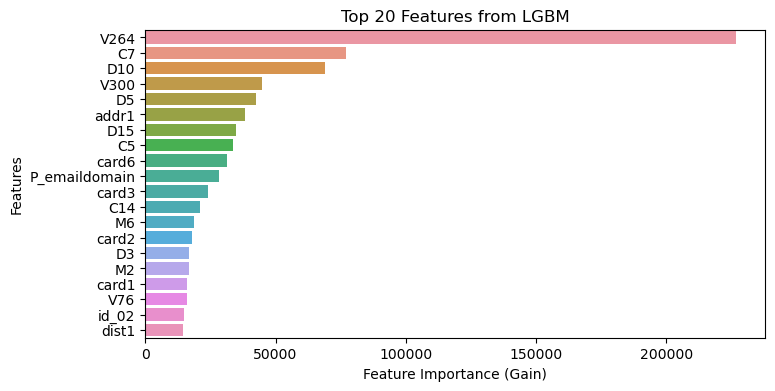

In [205]:
# plot lgbm feature importance by gain

plt.figure(figsize=(8,4))
sns.barplot(data=lgbm_fscore_df.sort_values(by='importance_gain', ascending=False).head(20), x = 'importance_gain', y = 'features')
plt.title('Top 20 Features from LGBM')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.show()

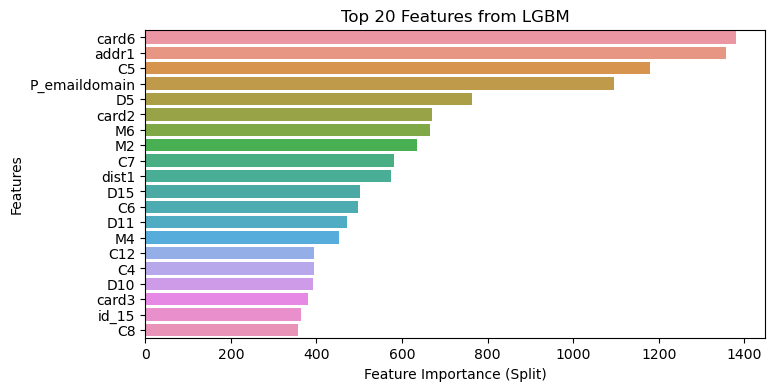

In [206]:
# plot lgbm feature importance by split

plt.figure(figsize=(8,4))
sns.barplot(data=lgbm_fscore_df.sort_values(by='importance_split', ascending = False).head(20), x = 'importance_split', y = 'features')
plt.title('Top 20 Features from LGBM')
plt.xlabel('Feature Importance (Split)')
plt.ylabel('Features')
plt.show()

## LGBM Model Result

In [163]:
result_lgbm_opt = model_auc_score(fitted_lgbm)

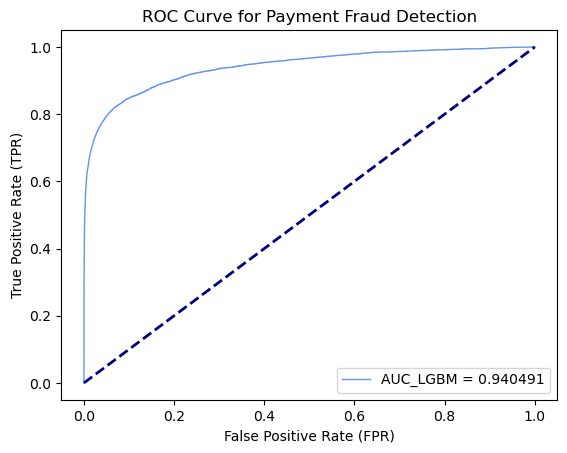

In [164]:
model_auc_plot(result_lgbm_opt, 'LGBM')

# Model Comparison

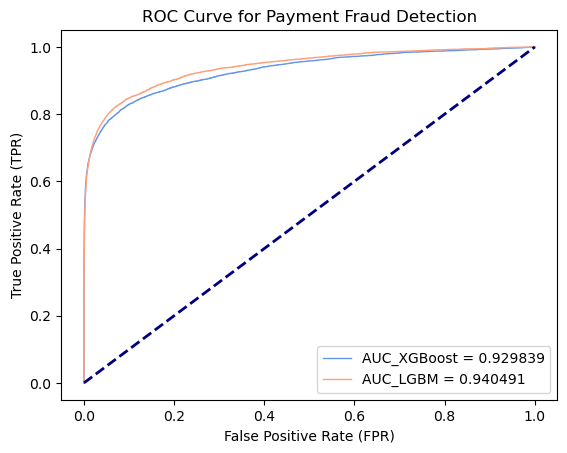

In [71]:
plt.figure()
plt.plot(result_xgbm_opt[1], result_xgbm_opt[2], color = 'cornflowerblue',
            lw=1, label = f'AUC_XGBoost = %0.6f' % result_xgbm_opt[0])
plt.plot(result_lgbm_opt[1], result_lgbm_opt[2], color = 'lightsalmon',
            lw=1, label = f'AUC_LGBM = %0.6f' % result_lgbm_opt[0])
plt.plot()
plt.plot([0, 1], [0, 1], color = 'navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Payment Fraud Detection')
plt.legend(loc="best")
plt.show()

Further feature engineering and model improvement TBC...